# Ugly Research Code

This comes with no warranty. All of the packages used have been updated since this code was first written, and there appear to be some issues with lifelines in particular for some of its plots. I was not smart enough to record the original software versions of everything (the irony is not lost on me given the subject matter). But this contains code that should generally be able to replicate all the results from my paper _Research Reproducibility as a Survival Analysis_. I hope it is useful to you, and it also contains other plots that did not make it into the paper! 

In [1]:
import shap
import xgboost
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt

from lifelines.statistics import proportional_hazard_test, TimeTransformers, StatisticalResult
from lifelines.utils.lowess import lowess
import tikzplotlib as matplotlib2tikz
from lifelines.utils import k_fold_cross_validation
from lifelines import KaplanMeierFitter

import seaborn as sns
import os


In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)


In [3]:
import optuna


In [4]:
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams.update({'figure.autolayout': True})


In [5]:
data = pd.read_csv("BLIND_reproducable_2.0.csv")

In [6]:
tmp = data[(data['Time to Implement'] != '#NUM!') & (data['Reproduced'] == 'Yes')]
mean_repro_time = tmp['Time to Implement'].astype('int32').mean()
median_repro_time = tmp['Time to Implement'].astype('int32').median()

In [7]:
mean_repro_time, median_repro_time

(218.82222222222222, 53.5)

In [8]:
tmp['Time to Implement'].astype('int32').max()

1687

In [9]:
if not os.path.exists('figs'):
    os.makedirs('figs')

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.


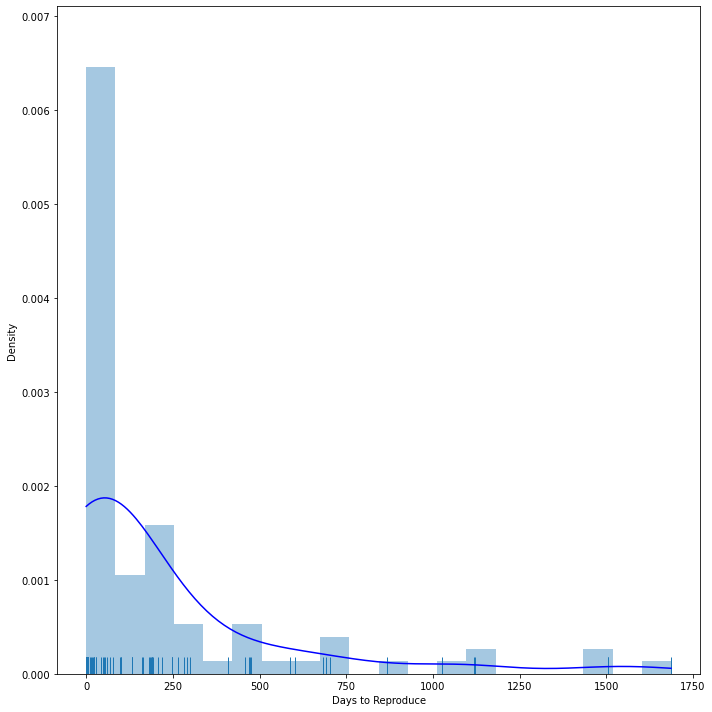

In [10]:

sns.distplot(tmp['Time to Implement'].values.astype(np.int32), bins=20, rug=True, kde=False, norm_hist=True)
ax = sns.kdeplot(tmp['Time to Implement'].values.astype(np.int32), cut=0, color="b")
ax.set(xlabel='Days to Reproduce', ylabel='Density')

plt.savefig("figs/reproduction_time_dist.pdf", dpi=300)
matplotlib2tikz.save("figs/reproduction_time_dist.tex")

In [11]:
for i in range(data.shape[0]):
    z = data.iloc[i]['Time to Implement']
    if z != "#NUM!" and np.isnan(float(z)):
        data.at[i,'Time to Implement'] = mean_repro_time

In [12]:
#Filter out rows of data for reproduced papers, where we don't know how long it took to reproduce
data = data[data['Time to Implement'] != '#NUM!']

In [13]:
OBSERVED = 1
CENSORED = 0



In [14]:
binary_options = ['Reproduced', 'Has Appendix', 'Uses Exemplar Toy Problem', 'Exact Compute Used', 
                  'Looks Intimidating', 'Data Available', 'Author Code Available']

for op in binary_options:
    data[op].replace('Yes', OBSERVED, inplace=True)
    data[op].replace('No', CENSORED, inplace=True)
    data[op].replace(np.nan, CENSORED, inplace=True)


In [15]:
data = data.drop('Normalized Total Tables and Figures', axis=1)

In [16]:
feature_data_raw = data[['Reproduced', 'Time to Implement', 
                         'Year', 'Year Attempted',
        'Hyperparameters Specified', 
        #Multiple values
        'Paper Readability', 'Algo Difficulty', 'Pseudo Code',
        #Binary
        'Has Appendix', 'Uses Exemplar Toy Problem', 'Exact Compute Used', 
                  'Looks Intimidating', 'Data Available', 'Author Code Available',
       'Rigor vs Empirical', 
        'Number of Authors', 'Pages',
       'Normalized Num References', 'Normalized Number of Equations',
       'Normalized Number of Proofs', 
       'Normalized Number of Tables', 'Normalized Number of Graphs/Plots',
       'Normalized Number of Other Figures',
       'Normalized Conceptualization Figures']]

In [17]:
# feature_data

In [18]:
feature_data = pd.get_dummies(feature_data_raw, 
    columns=[
         'Hyperparameters Specified', 
        'Paper Readability', 'Algo Difficulty', 'Pseudo Code',
       'Rigor vs Empirical'
    ]).astype('float32')

In [19]:
from lifelines.datasets import load_rossi
from lifelines import CoxPHFitter


In [20]:
rossi_dataset = load_rossi()


In [21]:
feature_data.isnull().values.sum()

0

In [22]:
# feature_data[feature_data.isnull().any(axis=1)]

In [23]:
cph = CoxPHFitter(penalizer=0.01)

cph.fit(feature_data, duration_col='Time to Implement', event_col='Reproduced', robust=True)


<lifelines.CoxPHFitter: fitted with 183 total observations, 93 right-censored observations>

In [24]:
cph.print_summary()  # access the results using cph.summary


model,lifelines.CoxPHFitter
duration col,'Time to Implement'
event col,'Reproduced'
penalizer,0.01
l1 ratio,0
robust variance,True
baseline estimation,breslow
number of observations,183
number of events observed,90
partial log-likelihood,-331.61
time fit was run,2020-12-17 19:42:15 UTC


<AxesSubplot:ylabel='Density'>

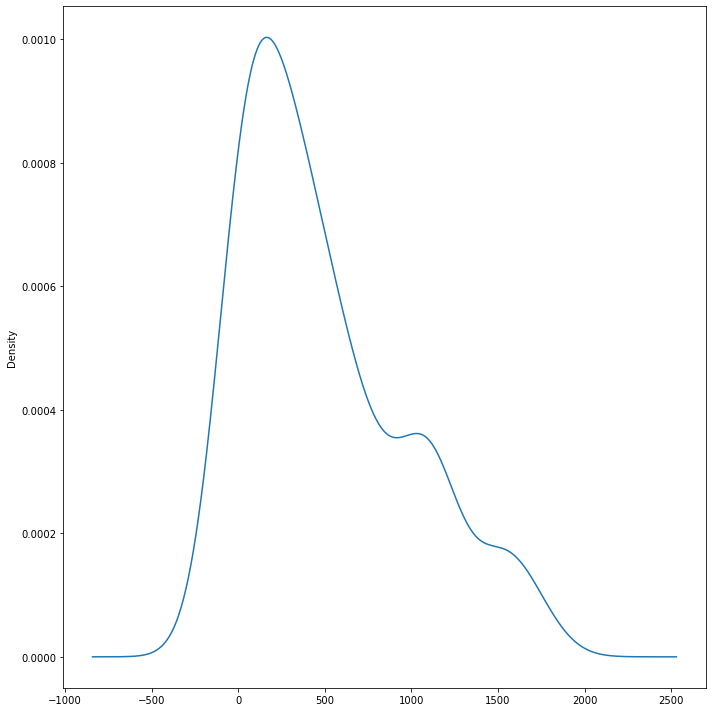

In [25]:
preds = cph.predict_median(feature_data)
preds.replace([np.inf, -np.inf], np.nan).plot.kde()



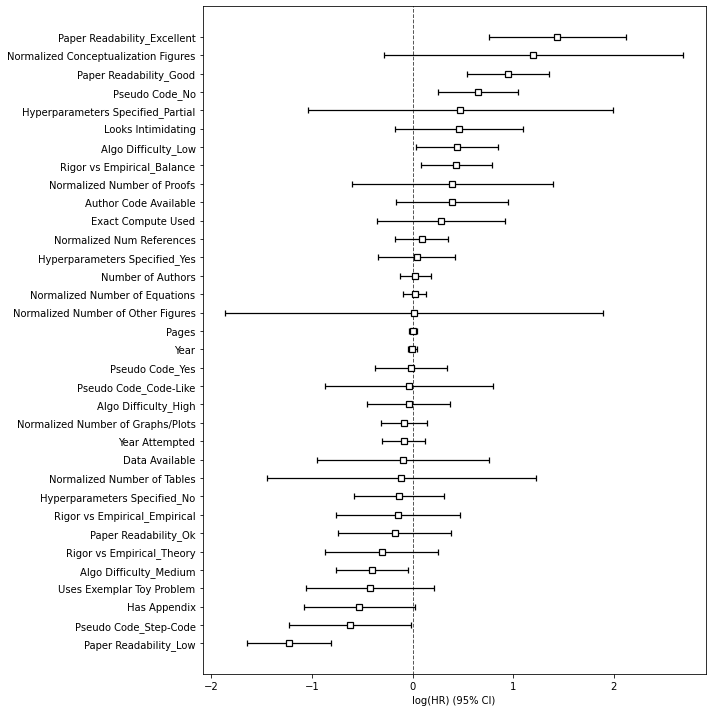

In [26]:

cph.plot()
plt.savefig("figs/cox_95_ci.pdf", dpi=300)



In [27]:
log_tim_data = feature_data.copy()
# log_tim_data['Time to Implement'] = log_tim_data['Time to Implement'].apply(lambda x: np.log(x+1))
log_tim_data['Time to Implement'] = log_tim_data['Time to Implement'].apply(lambda x: x)


In [28]:
cph = CoxPHFitter(penalizer=0.01)

cph.fit(log_tim_data, duration_col='Time to Implement', event_col='Reproduced', robust=True)



<lifelines.CoxPHFitter: fitted with 183 total observations, 93 right-censored observations>

In [29]:
cph.print_summary()  # access the results using cph.summary


model,lifelines.CoxPHFitter
duration col,'Time to Implement'
event col,'Reproduced'
penalizer,0.01
l1 ratio,0
robust variance,True
baseline estimation,breslow
number of observations,183
number of events observed,90
partial log-likelihood,-331.61
time fit was run,2020-12-17 19:42:16 UTC


In [34]:
plt.figure(figsize=(10,10))
try:
    cph.plot_covariate_groups('Normalized Conceptualization Figures', [0, 0.078724, 0.078724+0.158835*3, 1], cmap='coolwarm')
except:
    pass


<Figure size 720x720 with 0 Axes>

In [35]:
for var in cph.params_.index.values:
    
    save_name = "figs/cox_linear_surCurv_{}".format(var.replace("/", "_")).replace(" ", "_")
    
    print(save_name + ".pdf")
    try:
        vals = log_tim_data[var]
        if len(vals.unique()) <= 5: #Just plot the values!
            vals = np.sort(vals.unique())

            ax = cph.plot_covariate_groups(var, np.sort(vals), cmap='coolwarm')

        else:
            vals = vals.values

            x_min = np.min(vals)
            x_max = np.max(vals)
            x_avg = np.mean(vals)
            x_dev = np.std(vals)
            if x_min == 0:
                x_avg = np.mean(vals[np.nonzero(vals)])
                x_dev = np.std(vals[np.nonzero(vals)])

            a, b, c =  x_avg-x_dev, x_avg, x_avg+x_dev
            selected = [x_min, a, b, c, x_max]
            if np.equal(np.mod(vals, 1), 0).all(): #all integer values
                selected = np.unique([round(z) for z in selected])
            cph.plot_covariate_groups(var, selected, cmap='coolwarm')

        plt.savefig(save_name + ".pdf", dpi=300)
        matplotlib2tikz.save(save_name + ".tex")
    except:
        pass

    


figs/cox_linear_surCurv_Year.pdf
figs/cox_linear_surCurv_Year_Attempted.pdf
figs/cox_linear_surCurv_Has_Appendix.pdf
figs/cox_linear_surCurv_Uses_Exemplar_Toy_Problem.pdf
figs/cox_linear_surCurv_Exact_Compute_Used.pdf
figs/cox_linear_surCurv_Looks_Intimidating.pdf
figs/cox_linear_surCurv_Data_Available.pdf
figs/cox_linear_surCurv_Author_Code_Available.pdf
figs/cox_linear_surCurv_Number_of_Authors.pdf
figs/cox_linear_surCurv_Pages.pdf
figs/cox_linear_surCurv_Normalized_Num_References.pdf
figs/cox_linear_surCurv_Normalized_Number_of_Equations.pdf
figs/cox_linear_surCurv_Normalized_Number_of_Proofs.pdf
figs/cox_linear_surCurv_Normalized_Number_of_Tables.pdf
figs/cox_linear_surCurv_Normalized_Number_of_Graphs_Plots.pdf
figs/cox_linear_surCurv_Normalized_Number_of_Other_Figures.pdf
figs/cox_linear_surCurv_Normalized_Conceptualization_Figures.pdf
figs/cox_linear_surCurv_Hyperparameters_Specified_No.pdf
figs/cox_linear_surCurv_Hyperparameters_Specified_Partial.pdf
figs/cox_linear_surCurv_Hype

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 183 total observations, 93 right-censored observations>
         test_name = proportional_hazard_test

---
                                           test_statistic      p  -log2(p)
Algo Difficulty_High                 km              0.20   0.66      0.61
                                     rank            0.86   0.35      1.50
Algo Difficulty_Low                  km              2.27   0.13      2.92
                                     rank            5.11   0.02      5.39
Algo Difficulty_Medium               km              1.55   0.21      2.23
                                     rank            2.59   0.11      3.22
Author Code Available                km              0.85   0.36      1.48
                                     rank            0.48   0.49      1.03
Data Available                       km              0.41   0.52      0.94
                                     rank            1.68   0.20      2.36
Exact Compute Used                   km              0.10   0.75      0.41
                                     rank            0.01   0.93      0.10
Has Appendix                         km              3.67   0.06      4.18
                                     rank            3.06   0.08      3.64
Hyperparameters Specified_No         km              0.47   0.49      1.02
                                     rank            0.92   0.34      1.57
Hyperparameters Specified_Partial    km              0.58   0.45      1.16
                                     rank            0.02   0.89      0.17
Hyperparameters Specified_Yes        km              0.03   0.86      0.22
                                     rank            0.84   0.36      1.48
Looks Intimidating                   km              0.15   0.70      0.51
                                     rank            0.01   0.91      0.14
Normalized Conceptualization Figures km              0.45   0.50      0.99
                                     rank            0.28   0.60      0.74
Normalized Num References            km              0.00   0.99      0.01
                                     rank            0.05   0.82      0.29
Normalized Number of Equations       km              4.10   0.04      4.54
                                     rank            8.05 <0.005      7.78
Normalized Number of Graphs/Plots    km              0.00   0.99      0.01
                                     rank            0.09   0.76      0.39
Normalized Number of Other Figures   km              1.25   0.26      1.93
                                     rank            1.42   0.23      2.10
Normalized Number of Proofs          km              0.07   0.79      0.33
                                     rank            0.04   0.83      0.26
Normalized Number of Tables          km              0.87   0.35      1.51
                                     rank            1.21   0.27      1.89
Number of Authors                    km              1.64   0.20      2.32
                                     rank            0.71   0.40      1.32
Pages                                km              1.13   0.29      1.80
                                     rank            0.27   0.60      0.74
Paper Readability_Excellent          km              5.67   0.02      5.86
                                     rank            8.58 <0.005      8.20
Paper Readability_Good               km              1.00   0.32      1.65
                                     rank            0.39   0.53      0.91
Paper Readability_Low                km              1.35   0.25      2.02
                                     rank            1.27   0.26      1.94
Paper Readability_Ok                 km              2.89   0.09      3.49
                                     rank            5.25   0.02      5.51
Pseudo Code_Code-Like                km          



1. Variable 'Year Attempted' failed the non-proportional test: p-value is 0.0022.

   Advice: with so few unique values (only 6), you can include `strata=['Year Attempted', ...]` in
the call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


2. Variable 'Normalized Number of Equations' failed the non-proportional test: p-value is 0.0046.

   Advice 1: the functional form of the variable 'Normalized Number of Equations' might be
incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is very
sensitive to incorrect functional forms. See documentation in link [D] below on how to specify a
functional form.

   Advice 2: try binning the variable 'Normalized Number of Equations' using pd.cut, and then
specify it in `strata=['Normalized Number of Equations', ...]` in the call in `.fit`. See
documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documen

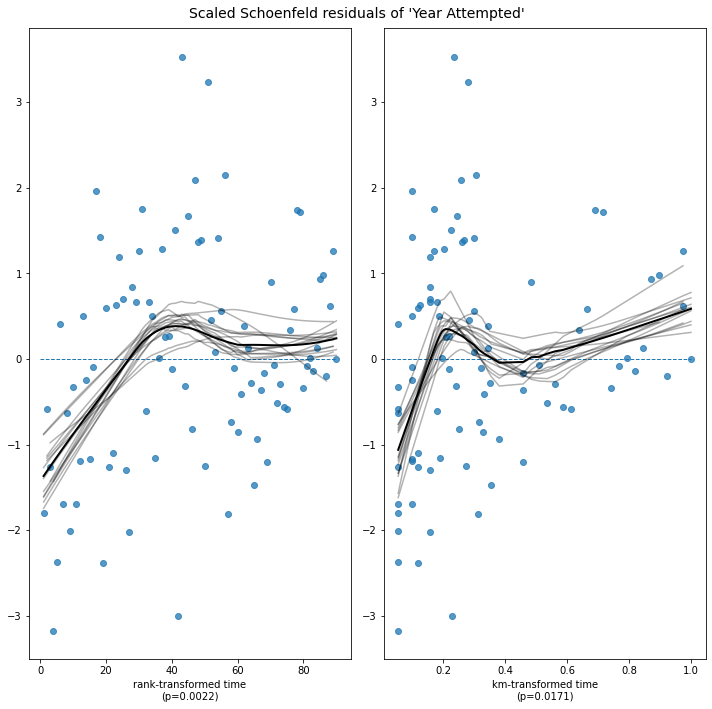

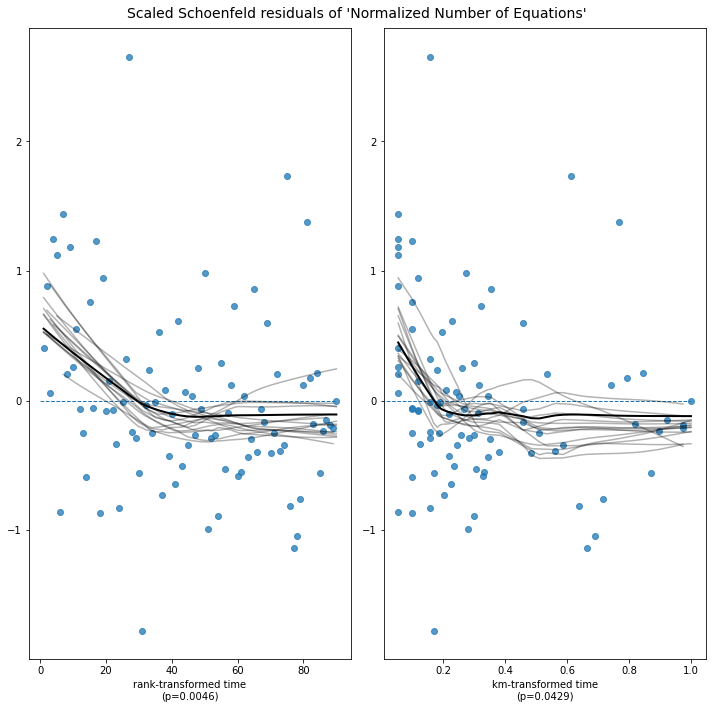

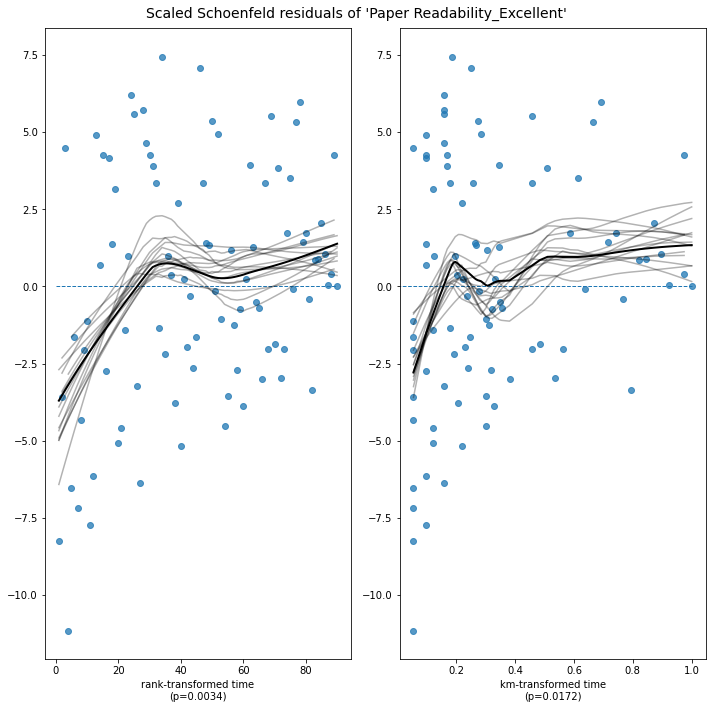

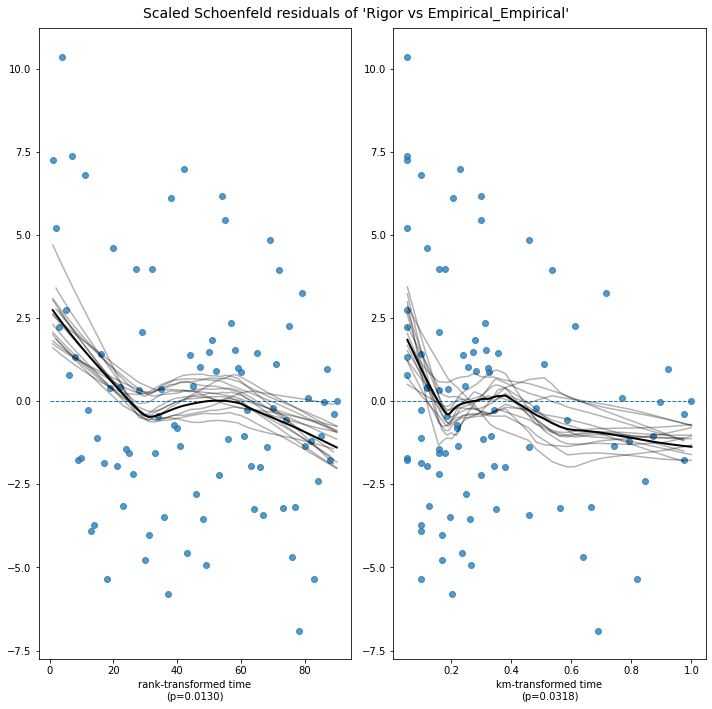

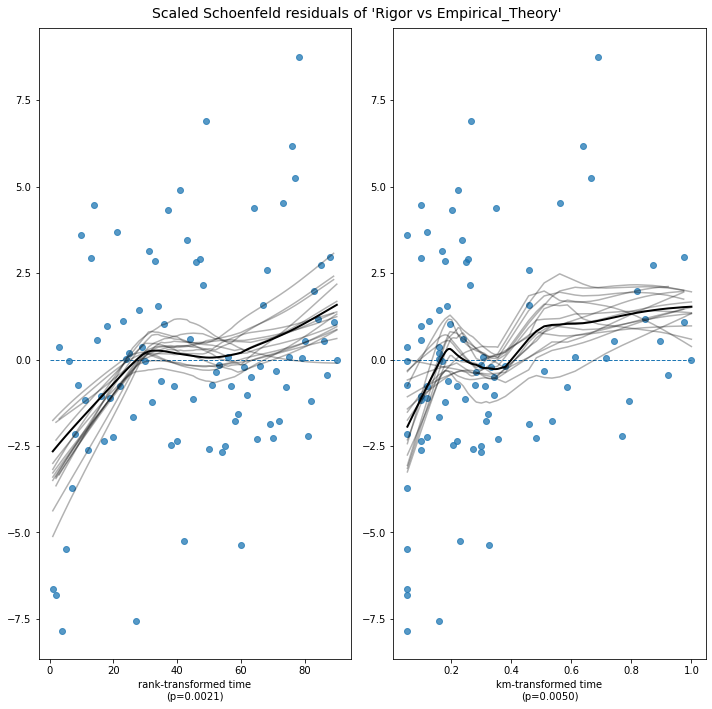

In [36]:
cph.check_assumptions(log_tim_data, show_plots=True)
plt.savefig("figs/cox_linear_residual.pdf", dpi=300)

In [37]:
residuals = cph.compute_residuals(log_tim_data, 'scaled_schoenfeld')
test_results = proportional_hazard_test(
            cph, log_tim_data, time_transform=["rank", "km"], precomputed_residuals=residuals)
residuals_and_duration = residuals.join(log_tim_data['Time to Implement'])
n = residuals_and_duration.shape[0]

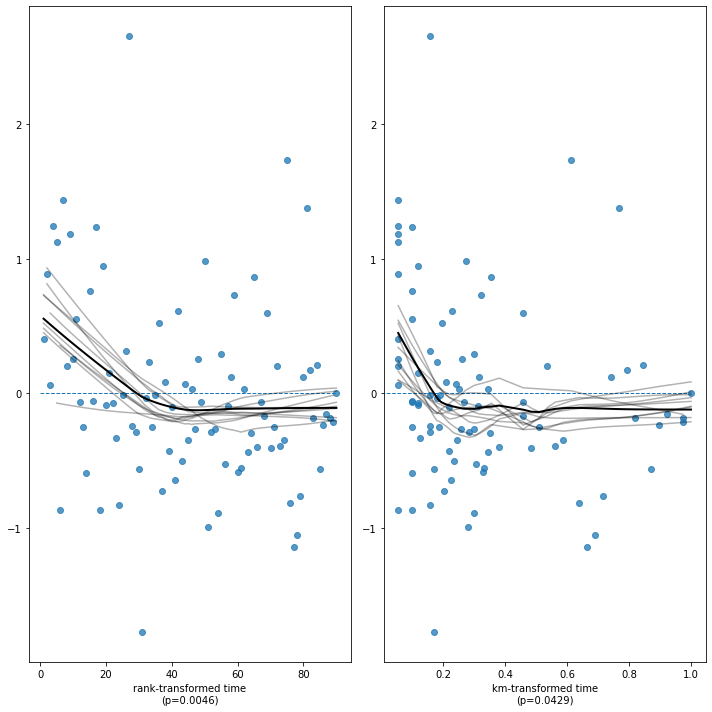

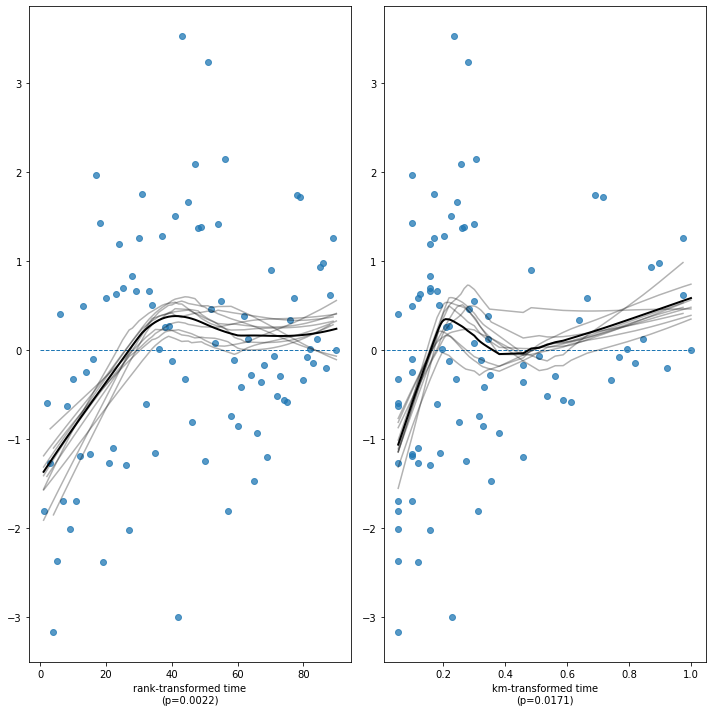

In [38]:
variables = ['Normalized Number of Equations', 'Year Attempted']

for variable in variables:
    plot_n_bootstraps = 10

    fig = plt.figure()

    for i, (transform_name, transformer) in enumerate(TimeTransformers().iter(["rank", "km"]), start=1):
        p_value = test_results.summary.loc[(variable, transform_name), "p"]

        ax = fig.add_subplot(1, 2, i)

        y = residuals_and_duration[variable]
        tt = transformer(cph.durations, cph.event_observed, cph.weights)[cph.event_observed.values]

        ax.scatter(tt, y, alpha=0.75)

        y_lowess = lowess(tt.values, y.values)
        ax.plot(tt, y_lowess, color="k", alpha=1.0, linewidth=2)

        # bootstrap some possible other lowess lines. This is an approximation of the 100% confidence intervals
        for _ in range(plot_n_bootstraps):
            ix = sorted(np.random.choice(n, n))
            tt_ = tt.values[ix]
            y_lowess = lowess(tt_, y.values[ix])
            ax.plot(tt_, y_lowess, color="k", alpha=0.30)

        best_xlim = ax.get_xlim()
        ax.hlines(0, 0, tt.max(), linestyles="dashed", linewidths=1)
        ax.set_xlim(best_xlim)

        ax.set_xlabel("%s-transformed time\n(p=%.4f)" % (transform_name, p_value), fontsize=10)

    # fig.subtitle("Scaled Schoenfeld residuals of '%s'" % variable, fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.savefig("figs/cox_linear_residual_{}.pdf".format(variable).replace(" ", "_"), dpi=300)
    matplotlib2tikz.save("figs/cox_linear_residual_{}.tex".format(variable).replace(" ", "_"))


In [39]:
print(np.mean(k_fold_cross_validation(cph, log_tim_data, k=10, duration_col='Time to Implement', event_col='Reproduced')))


-1.0142008871510182


### Linear Cox SHAP

In [40]:
log_tim_data_trunk = feature_data.copy()
log_tim_data_trunk = log_tim_data_trunk.drop('Reproduced', axis=1)
log_tim_data_trunk = log_tim_data_trunk.drop('Time to Implement', axis=1)


lin_explainer = shap.LinearExplainer((np.asarray(cph.params_.values), 0.0), log_tim_data_trunk,
                                     feature_dependence="independent")
lin_shap_values = lin_explainer.shap_values(log_tim_data_trunk)

lin_explainer_cor = shap.LinearExplainer((np.asarray(cph.params_.values), 0.0), log_tim_data_trunk,
                                     feature_dependence="correlation")
lin_shap_values_cor = lin_explainer_cor.shap_values(log_tim_data_trunk)




The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
The option feature_perturbation="correlation" is has been renamed to feature_perturbation="correlation_dependent"!


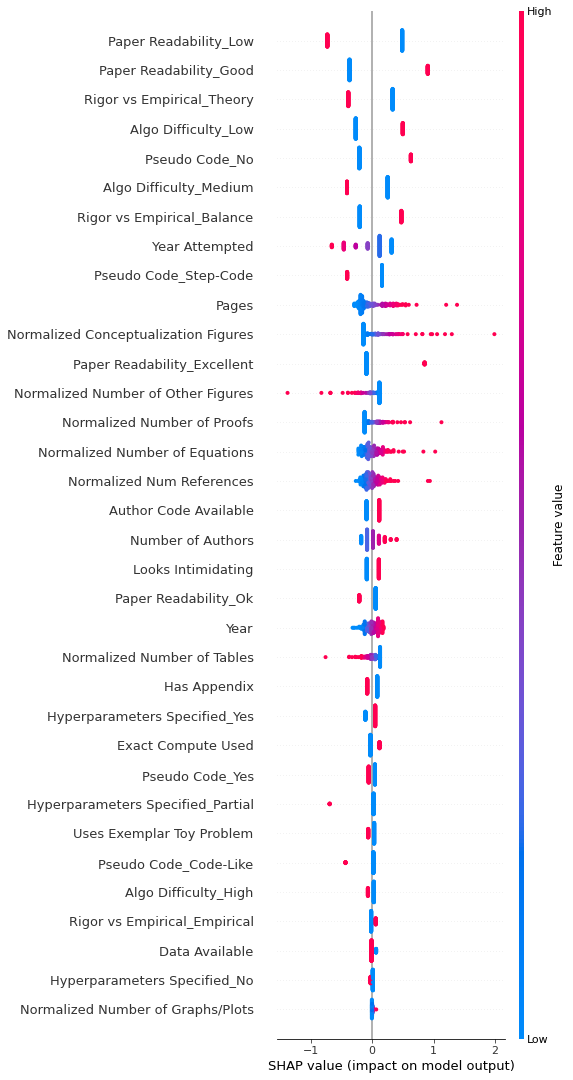

In [41]:
shap.summary_plot(lin_shap_values, log_tim_data_trunk, max_display=40, show=False)


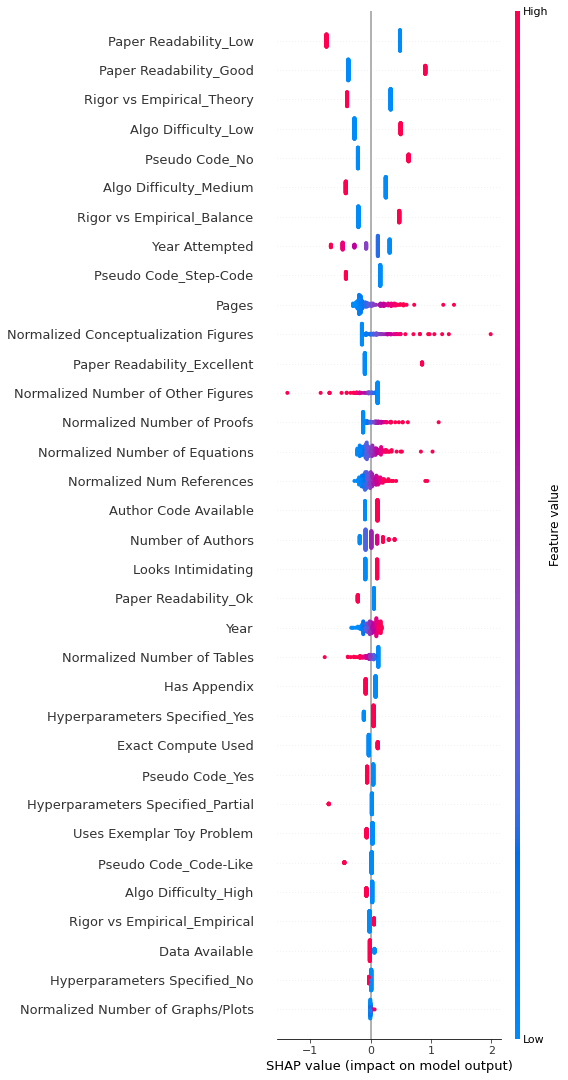

In [42]:
shap.summary_plot(lin_shap_values_cor, log_tim_data_trunk, max_display=40, show=False)
plt.savefig("figs/linear_cox_shap_cor.pdf", dpi=300)
matplotlib2tikz.save("figs/linear_cox_shap_cor.tex")

# Logistic Regression

In [43]:
feature_data_raw_bin = data[[
        #Multiple values
        'Paper Readability', 'Algo Difficulty', 'Pseudo Code',
        #Binary
        'Has Appendix', 'Exact Compute Used', 
                  'Looks Intimidating', 'Data Available', 'Author Code Available',
    
                         'Year', 'Year Attempted',
                         'Uses Exemplar Toy Problem',
       'Exact Compute Used', 
        'Hyperparameters Specified', 
       'Rigor vs Empirical', 
        'Number of Authors', 'Pages',
       'Normalized Num References', 'Normalized Number of Equations',
       'Normalized Number of Proofs', 
       'Normalized Number of Tables', 'Normalized Number of Graphs/Plots',
       'Normalized Number of Other Figures',
       'Normalized Conceptualization Figures']]

feature_data_bin = pd.get_dummies(feature_data_raw_bin, 
    columns=[
         'Hyperparameters Specified', 
        'Paper Readability', 'Algo Difficulty', 'Pseudo Code',
       'Rigor vs Empirical'
    ]).astype('float32')

In [44]:
logit = sm.Logit(data['Reproduced'], feature_data_bin)


In [45]:
# result = logit.fit()
result = logit.fit_regularized(alpha=0.01)

overflow encountered in exp


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3377523752860918
            Iterations: 432
            Function evaluations: 439
            Gradient evaluations: 432


QC check did not pass for 3 out of 35 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.


In [46]:
print(result.summary())


                           Logit Regression Results                           
Dep. Variable:             Reproduced   No. Observations:                  183
Model:                          Logit   Df Residuals:                      148
Method:                           MLE   Df Model:                           34
Date:                Thu, 17 Dec 2020   Pseudo R-squ.:                  0.5146
Time:                        14:45:18   Log-Likelihood:                -61.556
converged:                       True   LL-Null:                       -126.82
Covariance Type:            nonrobust   LLR p-value:                 3.087e-13
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Has Appendix                            -0.7133      0.558     -1.278      0.201      -1.807       0.380
Exact Compute Used                       0.3450   8.3

In [47]:
glm_model = sm.GLM(data['Reproduced'], feature_data_bin, 
                   family=sm.families.Binomial(link=sm.genmod.families.links.logit))
# families.Binomial(link=links.Logit)

In [48]:
result = glm_model.fit_regularized(alpha=0.1, L1_wt=1.0,  refit=True)
# result = glm_model.fit()

Elastic net fitting did not converge


In [49]:
# result.summary()

In [50]:
# feature_data

# Non Linear Shapely ANalysis

In [51]:
y = np.asarray(feature_data[['Time to Implement']].values).reshape(-1)
X = feature_data.iloc[:,2:]

for i in range(X.shape[0]):
    if feature_data.values[:,0][i] == 0: #Failed to repro, so right-censor 
        y[i] = -y[i]

In [52]:
xgb_full = xgboost.DMatrix(X, label=y)


In [53]:
def c_statistic_harrell(pred, labels):
    total = 0
    matches = 0
    for i in range(len(labels)):
        for j in range(len(labels)):
            if labels[j] > 0 and abs(labels[i]) > labels[j]:
                total += 1
                if pred[j] > pred[i]:
                    matches += 1
    return matches/total

# see how well we can order people by survival
# c_statistic_harrell(model_train.predict(xgb_test, ntree_limit=5000), y_test)
# c_statistic_harrell(model.predict(xgb_full), y)

In [54]:
def c_eval(predt: np.ndarray, dtrain: xgboost.DMatrix):# -> Tuple[str, float]:
    y = dtrain.get_label()
    
    return 'c', c_statistic_harrell(predt, y)

In [55]:
def objective(trial):
    depth = trial.suggest_int('max_depth', 3, 10)
    eta = trial.suggest_loguniform('eta', 0.003, 0.5)
    subsample = trial.suggest_uniform("subsample", 0.2, 0.7)
    rounds = trial.suggest_int('rounds', 10, 300)
    
    params = {
        "eta": eta,
        "max_depth": depth, 
        "objective": "survival:cox",
        "subsample": subsample,
        'silent':1
    }

    cv_results = xgboost.cv(
        params,
        xgb_full,
        num_boost_round=rounds,
        seed=42,
        nfold=10,
        feval=c_eval
    #     metrics={'survival:cox'}
    )
    
    return cv_results.tail(n=1)['test-c-mean'].values[0]


# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50)

# print(study.best_params)

In [56]:
# "Current best value is 0.797658 with parameters: {'max_depth': 8, 'eta': 0.015728069532410776, 'subsample': 0.2777431233700752, 'rounds': 69
params = {
    "eta": 0.015728069532410776,
    "max_depth": 8, 
    "objective": "survival:cox",
    "subsample": 0.2777431233700752,
    'silent': 1
}
boost_rounds = 69

In [57]:
cv_results = xgboost.cv(
    params,
    xgb_full,
    num_boost_round=boost_rounds,
    seed=42,
    nfold=10,
    feval=c_eval
)

[14:45:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:45:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:45:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only u

In [58]:
cv_results.tail(n=1)['test-c-mean'].values[0]
# cv_results['test-c-mean']

0.7987476000000001

In [59]:
model = xgboost.train(params, xgb_full, boost_rounds, evals = [(xgb_full, "test")], verbose_eval=1000)


[14:46:43] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[1]	test-cox-nloglik:4.13103
[2]	test-cox-nloglik:4.11576
[3]	test-cox-nloglik:4.10134
[4]	test-cox-nloglik:4.08834
[5]	test-cox-nloglik:4.08106
[6]	test-cox-nloglik:4.06400
[7]	test-cox-nloglik:4.05281
[8]	test-cox-nloglik:4.04077
[9]	test-cox-nloglik:4.03654
[10]	test-cox-nloglik:4.02555
[11]	test-cox-nloglik:4.01560
[12]	test-cox-nloglik:4.00844
[13]	test-cox-nloglik:3.99871
[14]	test-cox-nloglik:3.99465
[15]	test-cox-nloglik:3.98641
[16]	test-cox-nloglik:3.97932
[17]	test-cox-nloglik:3.97295
[18]	test-cox-nloglik:3.96925
[19]	test-cox-nloglik:3.96026
[20]	test-cox-nloglik:3.95256
[21]	test-cox-nl

In [60]:
shap_values = shap.TreeExplainer(model).shap_values(X)


In [61]:
y.max()

1687.0

In [62]:
tree_explainer = shap.TreeExplainer(model)
shap_interaction_values = tree_explainer.shap_interaction_values(X)


In [63]:

shape_noteraction_values = np.zeros_like(shap_values)

for i in range(shap_values.shape[1]):
    shape_noteraction_values[:,i] = shap_interaction_values[:,i,i]



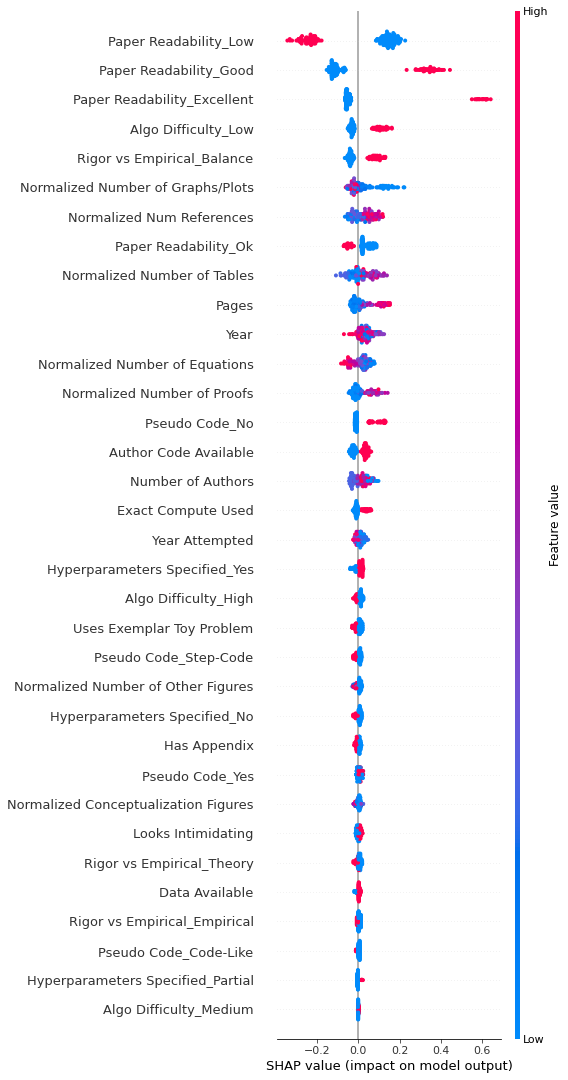

In [64]:
shap.summary_plot(shap_values, X, plot_type='dot', max_display=40, show=False)
plt.savefig("figs/xgboost_shape.pdf", dpi=300)

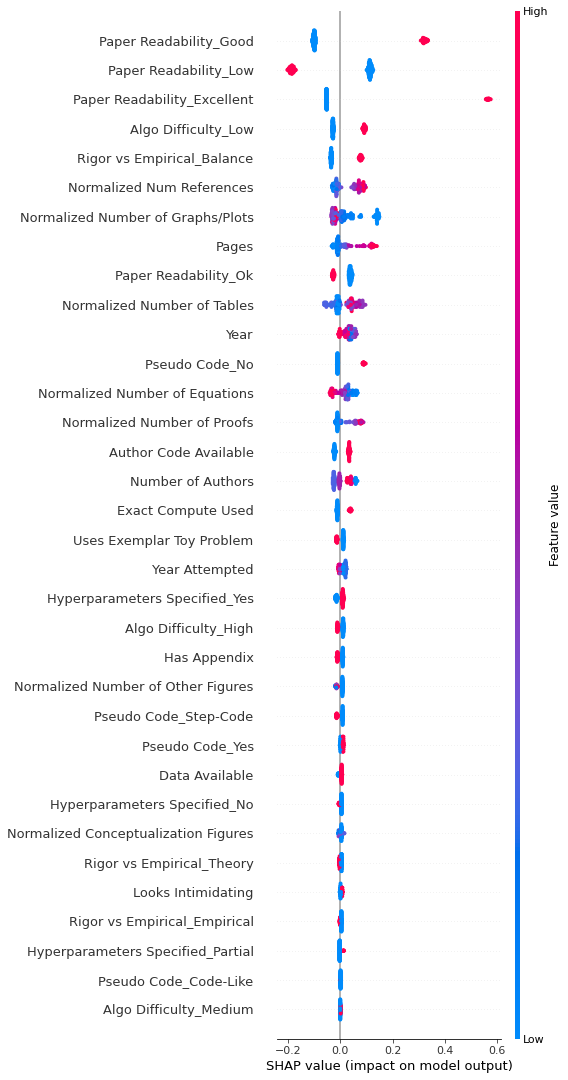

In [65]:
shap.summary_plot(shape_noteraction_values, X, max_display=40, show=False)
plt.savefig("figs/xgboost_shape_decor.pdf", dpi=300)

In [66]:
shape_noteraction_values.shape

(183, 34)

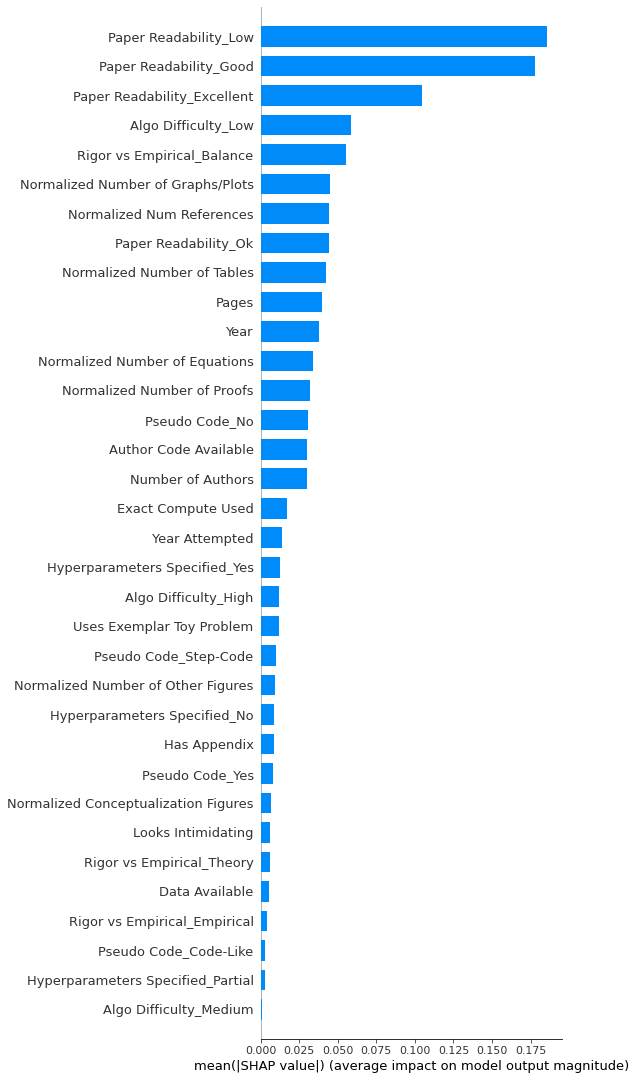

In [67]:
shap.summary_plot(shap_values, X, plot_type='bar', max_display=40)


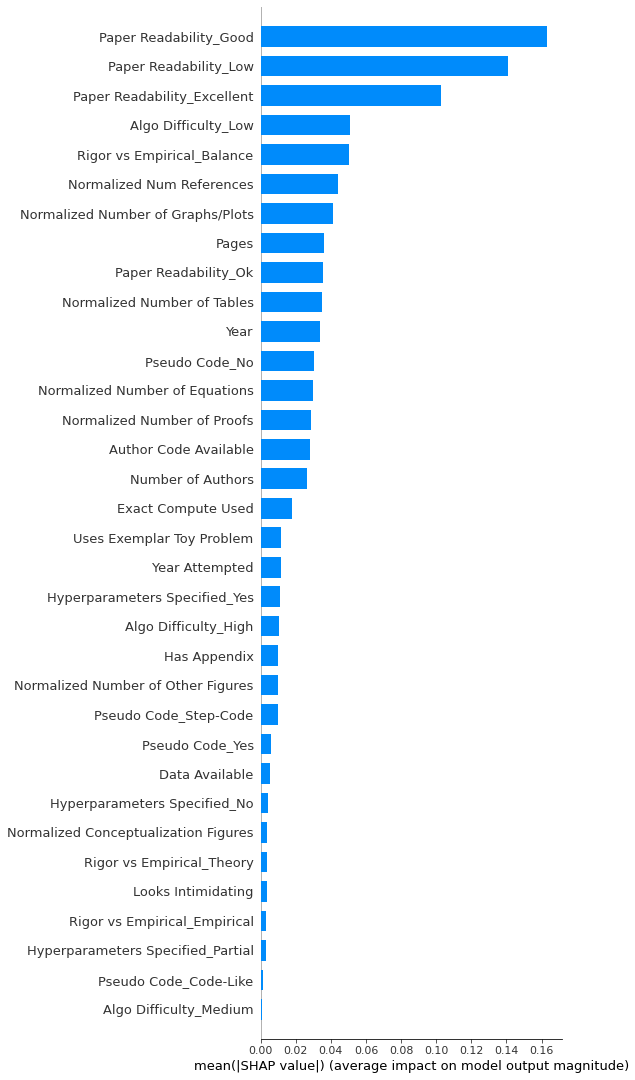

In [68]:
shap.summary_plot(shape_noteraction_values, X, max_display=40, plot_type='bar')


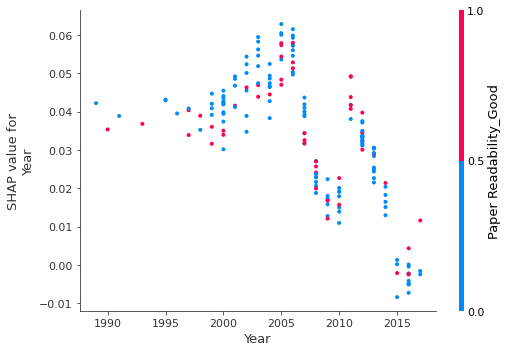

In [69]:
shap.dependence_plot("Year", shape_noteraction_values, X, show=False)
# plt.savefig("figs/xgboost_shape_decor_year.pdf", dpi=300)

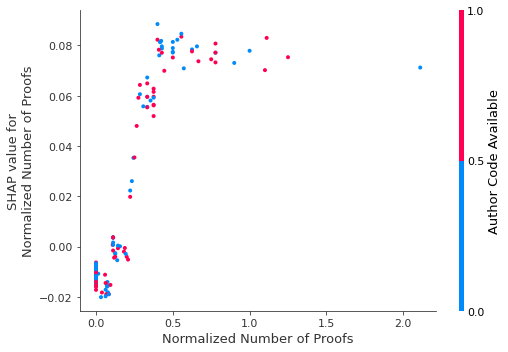

In [70]:
shap.dependence_plot("Normalized Number of Proofs", shape_noteraction_values, X)


In [71]:
# shap.summary_plot(shap_interaction_values, X)


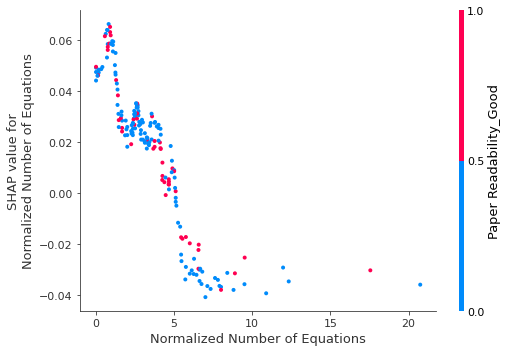

In [72]:
shap.dependence_plot("Normalized Number of Equations", shape_noteraction_values, X, show=False)
plt.savefig("figs/xgboost_shape_decor_equations.pdf", dpi=300)

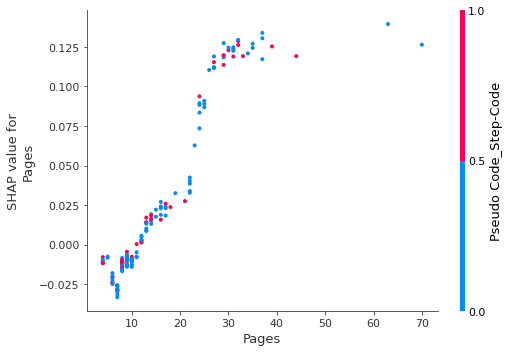

In [73]:
shap.dependence_plot("Pages", shape_noteraction_values, X, show=False)
plt.savefig("figs/xgboost_shape_decor_pages.pdf", dpi=300)

## Ordinal version of xgboost data

In [74]:
feature_data_ordinal = feature_data_raw.copy()
feature_data_ordinal.replace(to_replace={
    'Hyperparameters Specified': {'No': 0, 'Partial': 1, 'Yes': 2},
    'Paper Readability': {'Low': 0, 'Ok': 1, 'Good': 2, 'Excellent' : 3},
    'Algo Difficulty': {'Low': 0, 'Medium': 1, 'High': 2},
    'Pseudo Code': {'No': 0, 'Step-Code': 1, 'Yes': 2, 'Code-Like': 3}
                                        },
                             inplace=True)

feature_data_ordinal = pd.get_dummies(feature_data_ordinal, 
    columns=[
#         'Pseudo Code',
       'Rigor vs Empirical',
    ]).astype('float32')

X_ord = feature_data_ordinal.iloc[:,2:]
xgb_full_ord = xgboost.DMatrix(X_ord, label=y)



In [75]:
feature_data_ordinal['Data Available'].unique()

array([1., 0.], dtype=float32)

In [76]:
def objective(trial):
    depth = trial.suggest_int('max_depth', 3, 10)
    eta = trial.suggest_loguniform('eta', 0.003, 0.5)
    subsample = trial.suggest_uniform("subsample", 0.2, 0.7)
    rounds = trial.suggest_int('rounds', 10, 300)
    colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.3, 1.0)
    colsample_bylevel = trial.suggest_uniform("colsample_bylevel", 0.5, 1.0)
    lambda_ = trial.suggest_uniform("lambda", 0.1, 2.0)
    
    params = {
        "eta": eta,
        "max_depth": depth, 
        "objective": "survival:cox",
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "colsample_bylevel": colsample_bylevel,
        "lambda": lambda_,
        'silent':1
    }

    cv_results = xgboost.cv(
        params,
        xgb_full_ord,
        num_boost_round=rounds,
        seed=42,
        nfold=10,
        feval=c_eval
    )
    
    return cv_results.tail(n=1)['test-c-mean'].values[0]


# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# print(study.best_params)

In [77]:

# Current best value is 0.8021853999999999 with parameters: {'max_depth': 8, 
# 'eta': 0.02126844892731846, 'subsample': 0.20210001379297854, 'rounds': 120,
# 'colsample_bytree': 0.37002203782589316, 'colsample_bylevel': 0.7085528974300124, 'lambda': 1.497998138207469}.

# "Current best value is 0.8090154"
params = {
    "objective": "survival:cox",
    "eta": 0.02126844892731846,
    "max_depth": 8, 
    "subsample": 0.20210001379297854,
    'colsample_bytree': 0.37002203782589316, 
    'colsample_bylevel': 0.7085528974300124, 
    'lambda': 1.497998138207469,
    'silent': 1
}
boost_rounds = 120





In [79]:
# cv_results_ord = xgboost.cv(
#     params,
#     xgb_full_ord,
#     num_boost_round=boost_rounds,
#     seed=42,
#     nfold=10,
#     feval=c_eval
# )
# cv_results_ord.tail(n=1)['test-c-mean'].values[0]


In [80]:
model_ord = xgboost.train(params, xgb_full_ord, boost_rounds, evals = [(xgb_full_ord, "test")], verbose_eval=1000)


[14:50:27] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[1]	test-cox-nloglik:4.15122
[2]	test-cox-nloglik:4.14504
[3]	test-cox-nloglik:4.14051
[4]	test-cox-nloglik:4.13887
[5]	test-cox-nloglik:4.12187
[6]	test-cox-nloglik:4.12046
[7]	test-cox-nloglik:4.11503
[8]	test-cox-nloglik:4.11226
[9]	test-cox-nloglik:4.11070
[10]	test-cox-nloglik:4.10150
[11]	test-cox-nloglik:4.09725
[12]	test-cox-nloglik:4.09780
[13]	test-cox-nloglik:4.08804
[14]	test-cox-nloglik:4.08670
[15]	test-cox-nloglik:4.08775
[16]	test-cox-nloglik:4.08267
[17]	test-cox-nloglik:4.07208
[18]	test-cox-nloglik:4.07131
[19]	test-cox-nloglik:4.06599
[20]	test-cox-nloglik:4.06119
[21]	test-cox-nl

In [81]:
shap_values_ord = shap.TreeExplainer(model_ord).shap_values(X_ord)
tree_explainer_ord = shap.TreeExplainer(model_ord)
shap_interaction_values_ord = tree_explainer_ord.shap_interaction_values(X_ord)


shape_noteraction_values_ord = np.zeros_like(shap_values_ord)

for i in range(shap_values_ord.shape[1]):
    shape_noteraction_values_ord[:,i] = shap_interaction_values_ord[:,i,i]


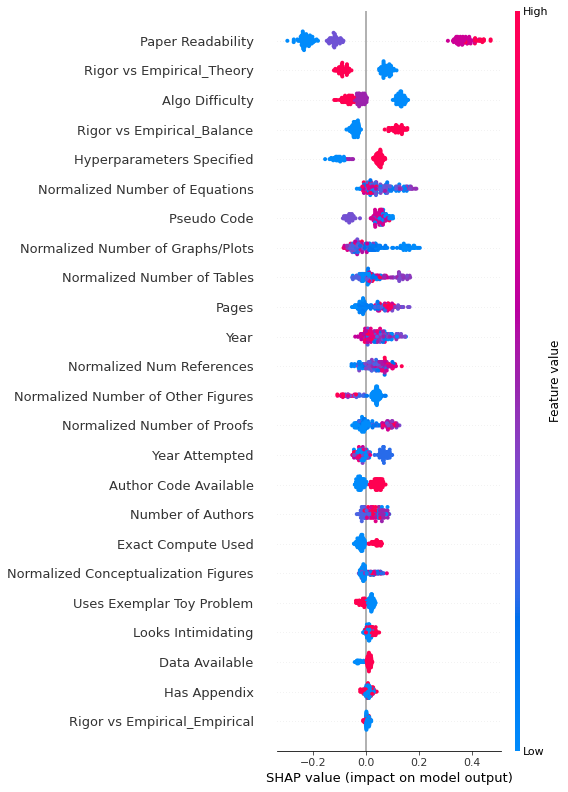

In [82]:
shap.summary_plot(shap_values_ord, X_ord, max_display=40, show=False)
plt.savefig("figs/xgboost_shape_ord.pdf", dpi=300)

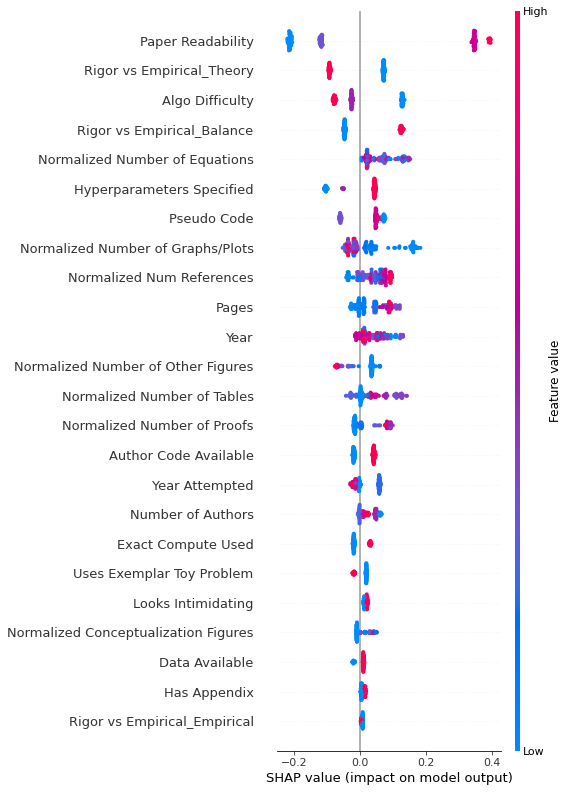

In [83]:
shap.summary_plot(shape_noteraction_values_ord, X_ord, max_display=40, show=False)
plt.savefig("figs/xgboost_shape_decor_ord.pdf", dpi=300)

In [84]:
feature_data_ordinal.columns[2:]

Index(['Year', 'Year Attempted', 'Hyperparameters Specified',
       'Paper Readability', 'Algo Difficulty', 'Pseudo Code', 'Has Appendix',
       'Uses Exemplar Toy Problem', 'Exact Compute Used', 'Looks Intimidating',
       'Data Available', 'Author Code Available', 'Number of Authors', 'Pages',
       'Normalized Num References', 'Normalized Number of Equations',
       'Normalized Number of Proofs', 'Normalized Number of Tables',
       'Normalized Number of Graphs/Plots',
       'Normalized Number of Other Figures',
       'Normalized Conceptualization Figures', 'Rigor vs Empirical_Balance',
       'Rigor vs Empirical_Empirical', 'Rigor vs Empirical_Theory'],
      dtype='object')

## Plot shap interactions but take into account exact results used from above

In [85]:
np.mean(np.abs(shap_interaction_values_ord[:,0,0]))

0.044082403

In [86]:
for i, col in enumerate(feature_data_ordinal.columns[2:]):
    max_inter = 0, None
    print(col)
    for j, interact in enumerate(feature_data_ordinal.columns[2:]):
        if interact == col:
            continue
#         print(i, j)
        score = np.mean(np.abs(shap_interaction_values_ord[:,i,j]))
        print("\t", interact, score)
        if score > max_inter[0]:
            max_inter = score, interact
        
#     print(col, max_inter)

Year
	 Year Attempted 0.002715098
	 Hyperparameters Specified 0.001687211
	 Paper Readability 0.0064630248
	 Algo Difficulty 0.0025870765
	 Pseudo Code 0.0042727254
	 Has Appendix 0.0031092444
	 Uses Exemplar Toy Problem 0.0007293913
	 Exact Compute Used 0.0004305411
	 Looks Intimidating 0.0
	 Data Available 0.0013593913
	 Author Code Available 0.0025328412
	 Number of Authors 0.0022189657
	 Pages 0.0028128286
	 Normalized Num References 0.003387207
	 Normalized Number of Equations 0.0039348616
	 Normalized Number of Proofs 0.0034426274
	 Normalized Number of Tables 0.0049798964
	 Normalized Number of Graphs/Plots 0.0017414441
	 Normalized Number of Other Figures 0.0013292431
	 Normalized Conceptualization Figures 0.0020003966
	 Rigor vs Empirical_Balance 0.0016797484
	 Rigor vs Empirical_Empirical 0.0
	 Rigor vs Empirical_Theory 0.0008343172
Year Attempted
	 Year 0.0027150984
	 Hyperparameters Specified 0.0005240031
	 Paper Readability 0.0034747599
	 Algo Difficulty 0.0004728071
	 Pse

	 Normalized Number of Graphs/Plots 0.002039178
	 Normalized Number of Other Figures 0.0
	 Normalized Conceptualization Figures 0.0
	 Rigor vs Empirical_Balance 0.003962037
	 Rigor vs Empirical_Empirical 0.00058340596
	 Rigor vs Empirical_Theory 0.0017361206
Data Available
	 Year 0.0013593913
	 Year Attempted 0.0
	 Hyperparameters Specified 0.0
	 Paper Readability 0.0
	 Algo Difficulty 0.00010803539
	 Pseudo Code 0.0018770834
	 Has Appendix 0.0014284054
	 Uses Exemplar Toy Problem 0.0
	 Exact Compute Used 0.0
	 Looks Intimidating 0.0
	 Author Code Available 0.00076413056
	 Number of Authors 0.0
	 Pages 0.0005307965
	 Normalized Num References 0.0
	 Normalized Number of Equations 0.0
	 Normalized Number of Proofs 0.001611479
	 Normalized Number of Tables 0.0010717511
	 Normalized Number of Graphs/Plots 0.0017765498
	 Normalized Number of Other Figures 0.0
	 Normalized Conceptualization Figures 0.00015183864
	 Rigor vs Empirical_Balance 0.00097092515
	 Rigor vs Empirical_Empirical 0.0
	 

	 Data Available 0.0
	 Author Code Available 0.0016659477
	 Number of Authors 0.0019059944
	 Pages 0.0012247629
	 Normalized Num References 0.002479184
	 Normalized Number of Equations 0.0
	 Normalized Number of Proofs 0.0005021353
	 Normalized Number of Tables 0.0021666344
	 Normalized Number of Graphs/Plots 0.0019335664
	 Normalized Conceptualization Figures 0.00025635527
	 Rigor vs Empirical_Balance 0.0011489103
	 Rigor vs Empirical_Empirical 0.0
	 Rigor vs Empirical_Theory 0.00036799337
Normalized Conceptualization Figures
	 Year 0.0020003964
	 Year Attempted 0.0021126042
	 Hyperparameters Specified 0.0008347092
	 Paper Readability 0.0
	 Algo Difficulty 0.000265168
	 Pseudo Code 0.0020957077
	 Has Appendix 0.0
	 Uses Exemplar Toy Problem 0.0
	 Exact Compute Used 0.00078528596
	 Looks Intimidating 0.0
	 Data Available 0.00015183851
	 Author Code Available 0.0024507742
	 Number of Authors 0.0006026019
	 Pages 0.00075482996
	 Normalized Num References 0.0
	 Normalized Number of Equati

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


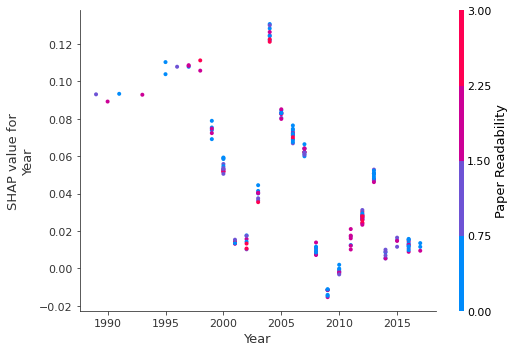

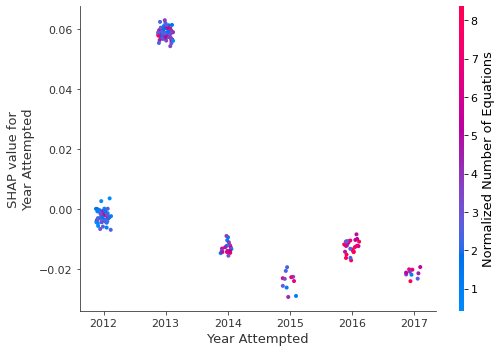

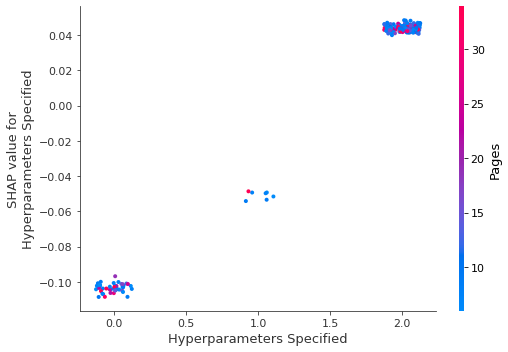

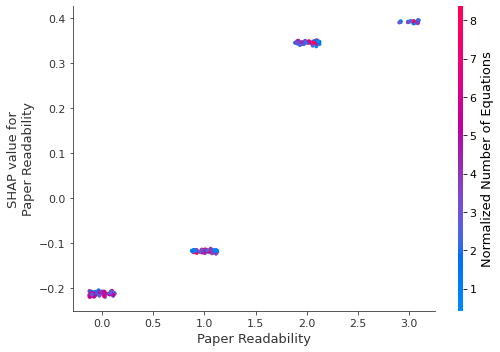

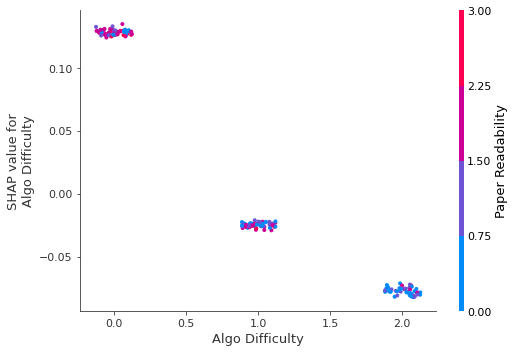

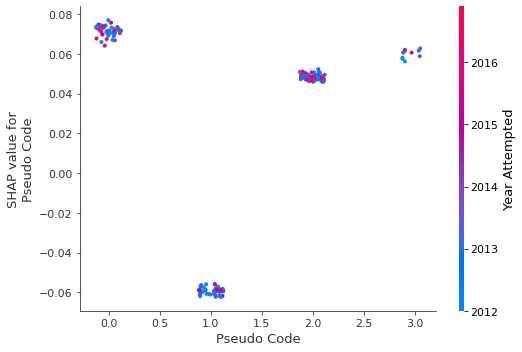

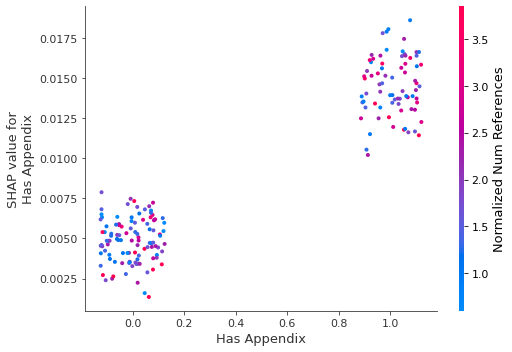

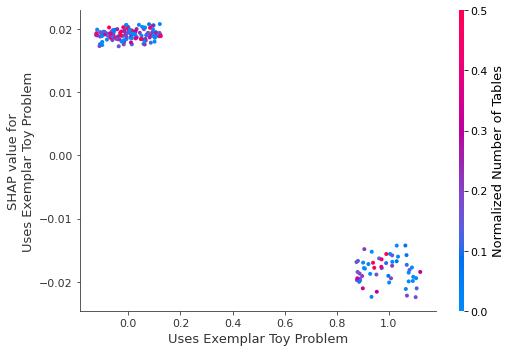

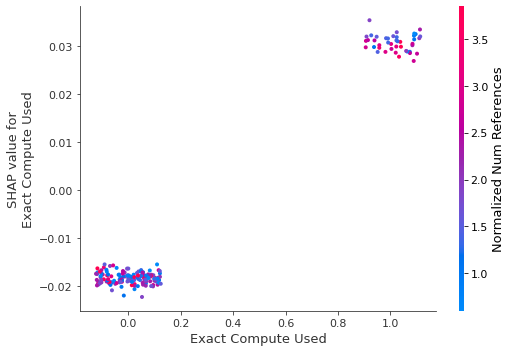

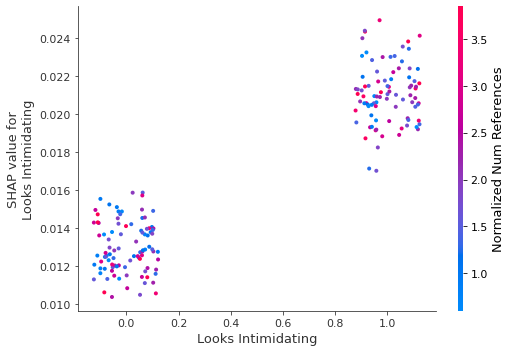

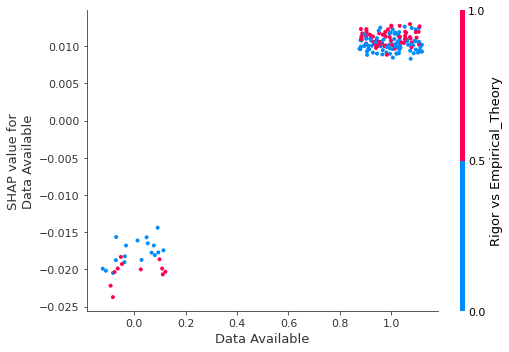

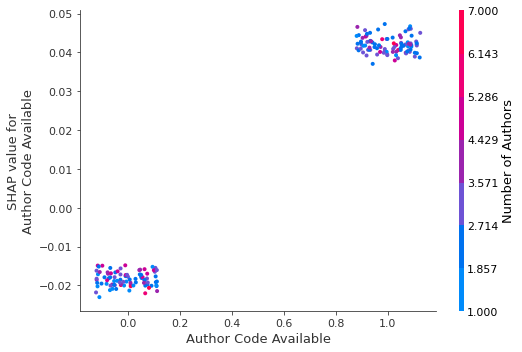

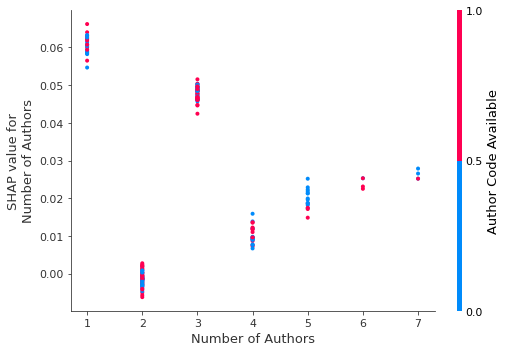

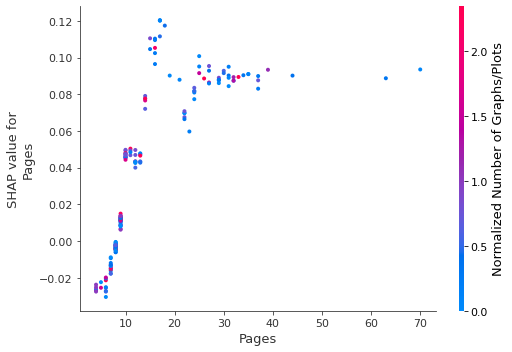

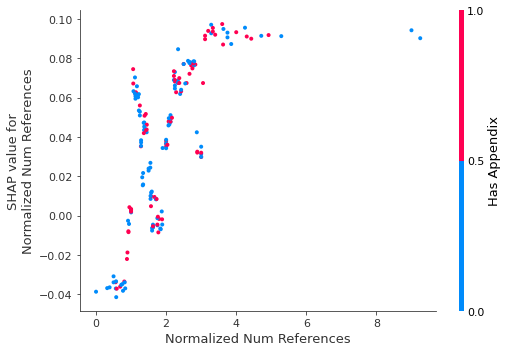

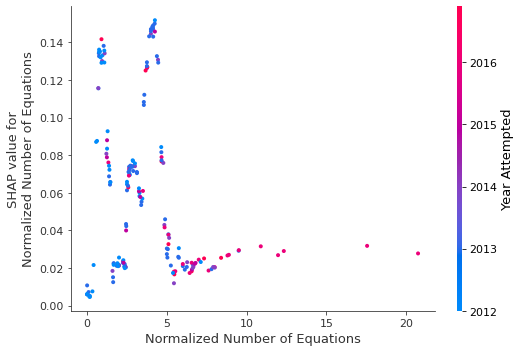

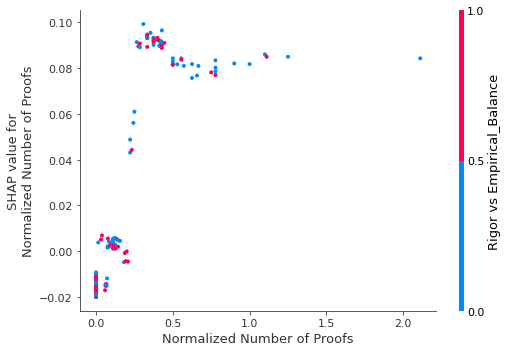

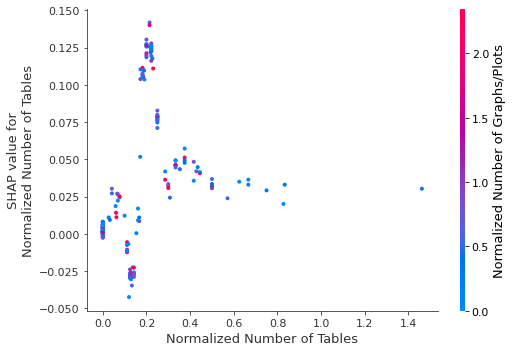

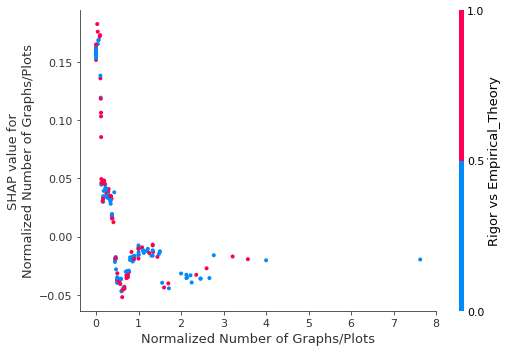

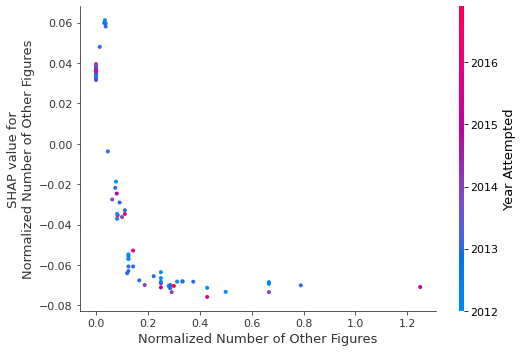

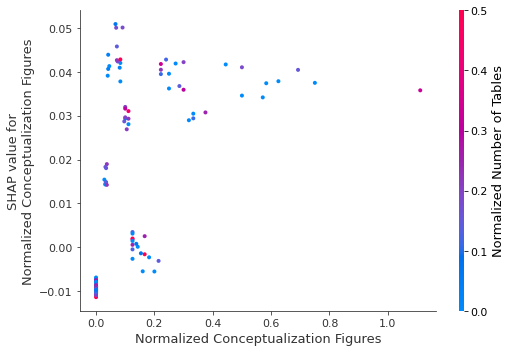

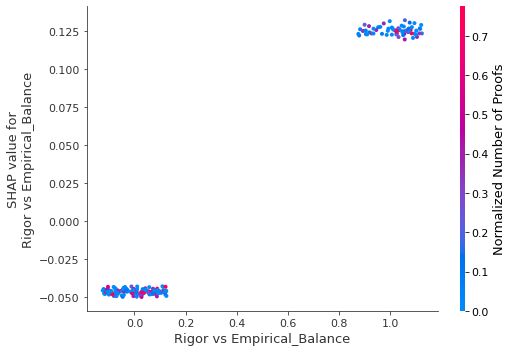

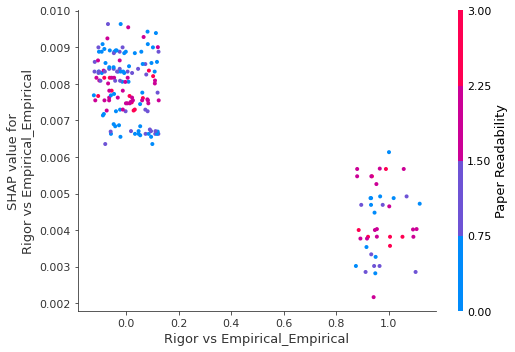

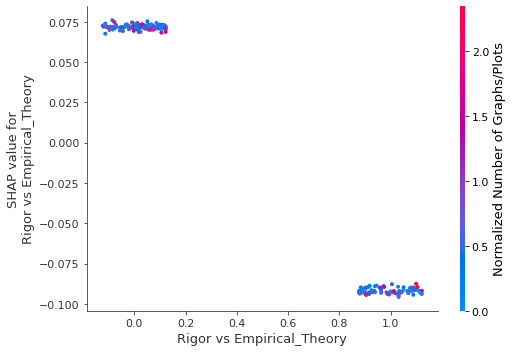

In [87]:
for i, col in enumerate(feature_data_ordinal.columns[2:]):

    max_inter = 0, None
#     print(col)
    for j, interact in enumerate(feature_data_ordinal.columns[2:]):
        if interact == col:
            continue
        score = np.mean(np.abs(shap_interaction_values_ord[:,i,j]))
        if score > max_inter[0]:
            max_inter = score, interact
            
    
    jitter = 0
    if len(feature_data_ordinal[col].unique()) <= 6:
        jitter = 0.25
    shap.dependence_plot(col, shape_noteraction_values_ord, X_ord,
                         interaction_index=max_inter[1],
                     x_jitter=jitter, show=False)
    col_n = col.replace(" ", "_").replace("/", "_")
    plt.savefig("figs/xgboost_shape_decor_{}.pdf".format(col_n), dpi=300)
    matplotlib2tikz.save("figs/xgboost_shape_decor_{}.tex".format(col_n))